In [17]:
import pathlib
import numpy as np
!pip install scikit-plot
import seaborn as sns
from matplotlib import pyplot
import scikitplot
from sklearn.metrics import classification_report
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle (1).json
User uploaded file "kaggle.json" with length 69 bytes


In [20]:
!pip install -q kaggle

In [21]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [22]:
!kaggle datasets download -d gauravsharma99/fer13-cleaned-dataset

fer13-cleaned-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [23]:
%mkdir -p dataset/
!unzip -q fer13-cleaned-dataset.zip -d dataset/

replace dataset/Angry/Training_10017485.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [24]:
INPUT_PATH = "/content/dataset/"

In [25]:
def print_image_distro():
  total_images=0
  for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
  return total_images

In [26]:
total_images = print_image_distro()
print(f"\ntotal images are {total_images}")

disgust has 380 number of images
Angry has 2832 number of images
Happy has 6834 number of images
Neutral has 4295 number of images
fear has 2535 number of images

total images are 16876


In [27]:
TOP_EMOTIONS = ["fear", "Happy", "Neutral", "Angry"]
total_images -= 380
total_images

16496

In [28]:
img_arr = np.empty(shape=(total_images,100,100,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}
i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            temp = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_arr[i] = cv2.resize(temp, (100, 100),interpolation=cv2.INTER_AREA)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all Angry images to numpy arrays
loaded all Happy images to numpy arrays
loaded all Neutral images to numpy arrays
loaded all fear images to numpy arrays


((16496, 100, 100, 3), array([0., 0., 0., ..., 3., 3., 3.]))

In [29]:
print(label_to_text)

{0: 'Angry', 1: 'Happy', 2: 'Neutral', 3: 'fear'}


In [30]:
img_arr.shape, img_label.shape

((16496, 100, 100, 3), (16496,))

In [31]:
img_arr = img_arr/255

In [32]:
unique_elements, counts_elements = np.unique(img_label, return_counts=True)

<BarContainer object of 4 artists>

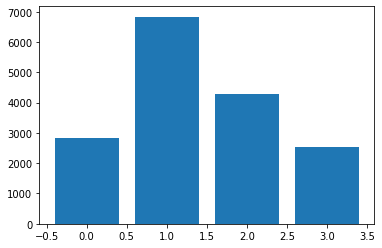

In [33]:
plt.bar(unique_elements,counts_elements)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14846, 100, 100, 3), (1650, 100, 100, 3), (14846,), (1650,))

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    shuffle=True, stratify=y_train,
                                                    train_size=0.85, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((12619, 100, 100, 3), (2227, 100, 100, 3), (12619,), (2227,))

In [36]:
def set_distro(x,y):
  unique_elements, counts_elements = np.unique(y, return_counts=True)
  plt.bar(unique_elements,counts_elements)

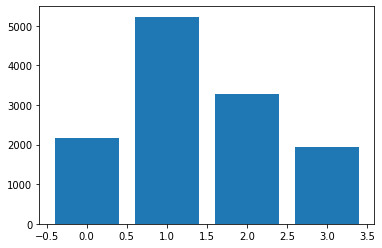

In [37]:
set_distro(X_train, y_train)

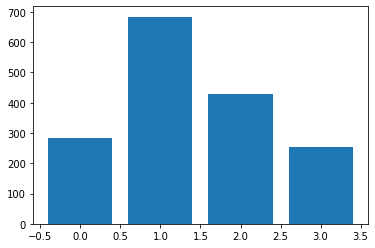

In [38]:
set_distro(X_test, y_test)

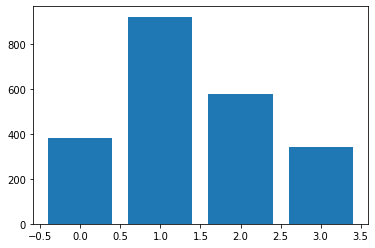

In [39]:
set_distro(X_val, y_val)

In [40]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_val = keras.utils.to_categorical(y_val)

In [41]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [42]:
num_classes

4

In [43]:
resnet = keras.applications.ResNet50(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

94781440/94765736 [==============================] - 1s 0us/step


In [44]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [45]:
x = resnet.output
global_pool = keras.layers.GlobalMaxPool2D(name="global_pool")(x)
out = keras.layers.Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = keras.models.Model(inputs=resnet.input, outputs=out)

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         

In [47]:
filepath="/content/resnet-{epoch:02d}-{val_accuracy:.2f}.hdf5"

In [48]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [49]:
batch_size = 16
epochs = 50
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size = batch_size),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    use_multiprocessing=True,
    callbacks = [model_checkpoint_callback]
)

Epoch 1/50
788/788 [==============================] - 159s 172ms/step - loss: 2.8502 - accuracy: 0.3924 - val_loss: 1.3292 - val_accuracy: 0.4154
Epoch 2/50
788/788 [==============================] - 130s 165ms/step - loss: 1.7152 - accuracy: 0.4057 - val_loss: 2.3673 - val_accuracy: 0.4522
Epoch 3/50
788/788 [==============================] - 130s 164ms/step - loss: 1.5169 - accuracy: 0.4357 - val_loss: 2.6083 - val_accuracy: 0.4378
Epoch 4/50
788/788 [==============================] - 129s 164ms/step - loss: 1.5856 - accuracy: 0.4199 - val_loss: 13.5598 - val_accuracy: 0.3485
Epoch 5/50
788/788 [==============================] - 129s 163ms/step - loss: 1.4802 - accuracy: 0.4205 - val_loss: 4.4959 - val_accuracy: 0.4333
Epoch 6/50
788/788 [==============================] - 129s 163ms/step - loss: 1.3245 - accuracy: 0.4683 - val_loss: 1.4508 - val_accuracy: 0.2573
Epoch 7/50
788/788 [==============================] - 130s 164ms/step - loss: 1.3163 - accuracy: 0.4977 - val_loss: 1.2038 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

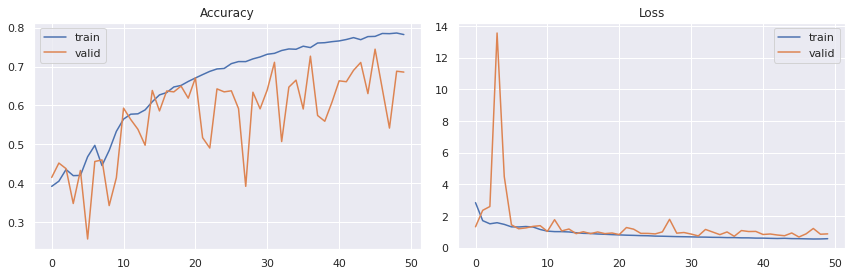

In [51]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_resnet.png')
pyplot.show()

In [63]:
model.load_weights('/content/resnet-46-0.74.hdf5')  

test accuracy: 73.9394 %


              precision    recall  f1-score   support

           0       0.65      0.51      0.57       283
           1       0.88      0.88      0.88       684
           2       0.64      0.80      0.71       430
           3       0.63      0.52      0.57       253

    accuracy                           0.74      1650
   macro avg       0.70      0.68      0.68      1650
weighted avg       0.74      0.74      0.73      1650



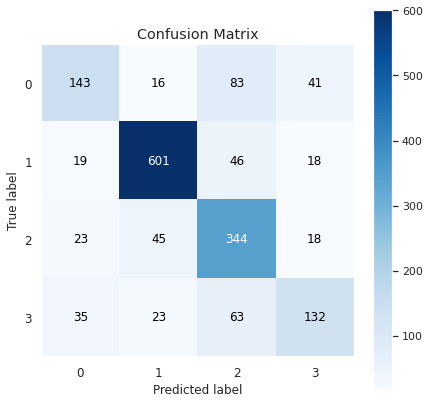

In [64]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_resnet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))


(48, 48)


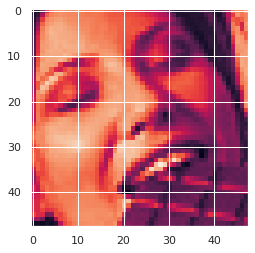

In [65]:
from keras.preprocessing import image
img = image.load_img('/content/dataset/Happy/Training_10000426.jpg',target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)

In [56]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (100, 100, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/content/dataset/Happy/Training_10000426.jpg')

result=model.predict(image)
result = list(result[0])
print(result)

[0.15595937, 0.45103922, 0.3097855, 0.08321589]


In [57]:
img_index = result.index(max(result))
print(label_to_text[img_index])
plt.show()

Happy


In [ ]:
model.save('/content/')

In [66]:
loaded_model = tf.keras.models.load_model('/content/')

In [67]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         